# FlexPower Quant Challenge - Task 2

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Preparation

In [ ]:
# Import Excel file into python as a dataframe
df = pd.read_excel('analysis_task_data.xlsx')

# Change the timestamp column into datetime and add date and month as a column
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')          # switch to a DatetimeIndex
df['hour']  = df.index.hour        
df['date']  = df.index.date
df['month'] = df.index.month

# Check for missing values
missing_values = df.isna().sum().sum()
print(f"Missing values detected: {missing_values}")

# Show summary statistics for all numeric columns
print("Summary statistics:")
print(df.describe())

Missing values detected: 0
Summary statistics:
               hour  Wind Day Ahead Forecast [in MW]  \
count  35040.000000                     35040.000000   
mean      11.500000                     13172.991581   
std        6.922285                     10086.192599   
min        0.000000                       114.000000   
25%        5.750000                      5467.750000   
50%       11.500000                     10195.500000   
75%       17.250000                     18749.250000   
max       23.000000                     48217.000000   

       Wind Intraday Forecast [in MW]  PV Day Ahead Forecast [in MW]  \
count                    35040.000000                   35040.000000   
mean                     12954.113527                    5261.937529   
std                       9860.537118                    8027.697147   
min                        127.000000                       0.000000   
25%                       5394.750000                       0.000000   
50%             

## Task 2.1

Each forecast value is in MW for a 15‑minute window. Since 15 min = 0.25 h multiplying by 0.25 converts power (MW) into energy (MWh) for that interval.

In [226]:
# Find all columns related to forecasts and drop the last three words from each column name
forecast_columns = [col for col in df.columns if "Forecast" in col]
shortened_labels = [" ".join(col.split()[:-3]) for col in forecast_columns]

for i, col in enumerate(forecast_columns):
    # MW on quarterly basis to MWh
    mwh_sum = (df[col] * 0.25).sum()
    print(f"2021 Total {shortened_labels[i]}: \t{mwh_sum:>14,.1f} MWh")



2021 Total Wind Day Ahead: 	 115,395,406.2 MWh
2021 Total Wind Intraday: 	 113,478,034.5 MWh
2021 Total PV Day Ahead: 	  46,094,572.8 MWh
2021 Total PV Intraday: 	  46,689,891.5 MWh


## Task 2.2

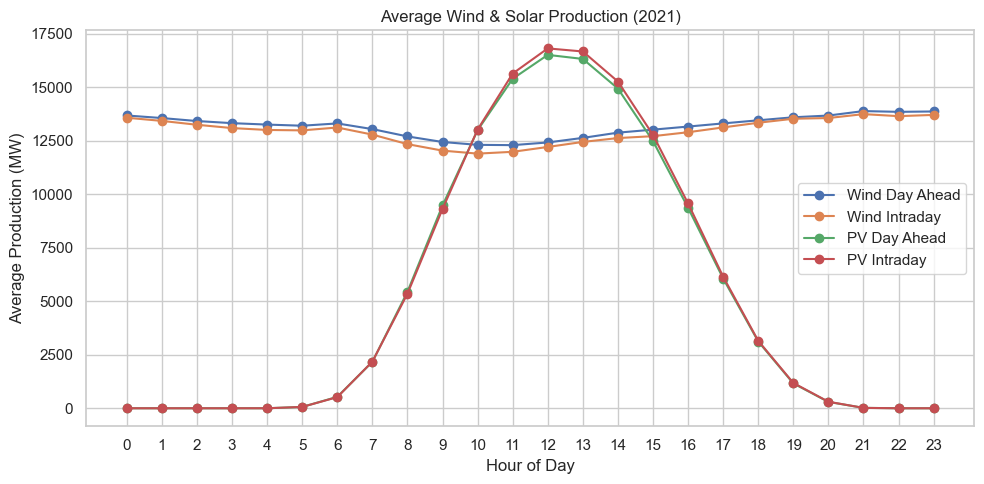

In [227]:
# Compute the hourly averages for all 4 time series 
hourly_avg = df.groupby('hour')[forecast_columns].mean()

# Plot the averages over the hours
hourly_avg.plot(figsize=(10, 5), marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Production (MW)')
plt.title('Average Wind & Solar Production (2021)')
plt.xticks(range(24))
plt.grid(True)
plt.legend(shortened_labels)
plt.tight_layout()
plt.show()

## Task 2.3

In [228]:
# Convert to MWh per 15 min block
wind_mwh = df['Wind Day Ahead Forecast [in MW]'] * 0.25
pv_mwh   = df['PV Day Ahead Forecast [in MW]']   * 0.25

# Get the Day ahead prices
da_price = df['Day Ahead Price hourly [in EUR/MWh]']

# Compute the wind/pv average value
avg_wind_price = (wind_mwh * da_price).sum() / wind_mwh.sum()
avg_pv_price   = (pv_mwh   * da_price).sum() / pv_mwh.sum()

# Compute the general average value
avg_market_price = da_price.mean()

# Print Results
print(f"Wind realized price:\t{avg_wind_price:.1f} EUR/MWh")
print(f"PV realized price:\t{avg_pv_price:.1f} EUR/MWh")
print(f"Market DA price:\t{avg_market_price:.1f} EUR/MWh")

Wind realized price:	81.4 EUR/MWh
PV realized price:	76.9 EUR/MWh
Market DA price:	96.8 EUR/MWh


In 2021, wind farms averaged 81.4 EUR/MWh and solar farms 76.9 EUR/MWh, below the day-ahead market price of 96.8 EUR/MWh. This difference occurs because wind generates mainly overnight, when demand is low and conventional plants can easily meet consumption, and solar peaks around midday, causing oversupply. Both factors push prices down. Additionally, renewables often aren't producing during high-demand periods—like a cold evening leading to tight renewable supply and higher market prices that wind and solar cannot benefit from.

## Task 2.4

In [229]:
# Day‑Ahead totals (MWh/day)
wind_mwh    = df['Wind Day Ahead Forecast [in MW]']    * 0.25
pv_mwh      = df['PV Day Ahead Forecast [in MW]']      * 0.25
da_total    = (wind_mwh + pv_mwh).groupby(df['date']).sum()

# Intraday totals (MWh/day)
wind_id_mwh = df['Wind Intraday Forecast [in MW]']    * 0.25
pv_id_mwh   = df['PV Intraday Forecast [in MW]']      * 0.25
id_total    = (wind_id_mwh + pv_id_mwh).groupby(df['date']).sum()

# Average day‑ahead price per day
daily_price = df.groupby('date')['Day Ahead Price hourly [in EUR/MWh]'].mean()

# Find extremes
da_max_day, da_min_day = da_total.idxmax(), da_total.idxmin()
id_max_day, id_min_day = id_total.idxmax(), id_total.idxmin()

# Print Day‑Ahead results
print(f"DA Highest on {da_max_day}: {da_total[da_max_day]:,.0f} MWh @ {daily_price[da_max_day]:.1f} EUR/MWh")
print(f"DA Lowest  on {da_min_day}: {da_total[da_min_day]:,.0f} MWh @ {daily_price[da_min_day]:.1f} EUR/MWh")

# Print Intraday extremes
print(f"ID Highest on {id_max_day}: {id_total[id_max_day]:,.0f} MWh")
print(f"ID Lowest  on {id_min_day}: {id_total[id_min_day]:,.0f} MWh")

# Check if the extreme days match
print("Max day match:", da_max_day == id_max_day)
print("Min day match:", da_min_day == id_min_day)


DA Highest on 2021-03-12: 1,088,041 MWh @ 22.3 EUR/MWh
DA Lowest  on 2021-11-16: 59,199 MWh @ 237.5 EUR/MWh
ID Highest on 2021-03-12: 1,091,920 MWh
ID Lowest  on 2021-11-16: 48,255 MWh
Max day match: True
Min day match: True


On March 12, 2021, wind and solar output peaked at roughly 1 088 041 MWh, yet the day‑ahead price plunged to just €22.3/MWh. By contrast, on November 16, 2021, renewables fell to about 59 199 MWh and the price soared to €237.5/MWh. This stark reversal reflects simple supply‑and‑demand: when abundant low‑marginal‑cost wind and solar flood the grid, prices collapse, whereas when those resources dwindle, more expensive conventional plants must fill the gap and drive prices upward.

Because this analysis focuses on day‑ahead market prices, I initially used day‑ahead forecasts to identify these extreme production days. However, intraday forecasts which better capture actual output as the delivery period approaches can shift those peaks and troughs. I therefore checked the intraday data and found the same two dates for highest and lowest renewable production, confirming that our conclusions aren’t an artifact of forecast timing.

## Task 2.5

In [230]:

# Create a boolean mask for weekdays (Mon–Fri) vs weekends (Sat–Sun)
weekday_mask = df.index.dayofweek < 5

# Select your DA price series
da_series = df['Day Ahead Price hourly [in EUR/MWh]']

# Select the day‑ahead prices for each group
weekday_prices = da_series[weekday_mask]
weekend_prices = da_series[~weekday_mask]

# Compute average and volatility for each
weekday_avg = weekday_prices.mean()
weekend_avg = weekend_prices.mean()
weekday_vol = weekday_prices.std()
weekend_vol = weekend_prices.std()

# Print results
print(f"Weekday avg DA price:      {weekday_avg:>6.1f} EUR/MWh")
print(f"Weekend avg DA price:      {weekend_avg:>6.1f} EUR/MWh")
print(f"Weekday price volatility:  {weekday_vol:>6.1f} EUR/MWh")
print(f"Weekend price volatility:  {weekend_vol:>6.1f} EUR/MWh")


Weekday avg DA price:       104.4 EUR/MWh
Weekend avg DA price:        78.0 EUR/MWh
Weekday price volatility:    77.4 EUR/MWh
Weekend price volatility:    59.4 EUR/MWh


The data show weekday day-ahead prices to be an average 104.4 EUR/MWh but only 78.0 EUR/MWh on weekends, and price volatility also more dramatic during the workweek (standard deviation of 77.4 EUR/MWh vs. 59.4 EUR/MWh on weekends). This is because commercial and industrial demand peaking sharply Monday through Friday drives both higher highs and lower lows as supply and demand constantly balance. On weekends, the consumption is more stable and predictable, fewer factories and offices operating so the market gets lower and more stabilized prices without the extreme volatility of a regular weekday.

## Task 2.6

First of all check the 24h pricing pattern for each month of the year to get some input for further development


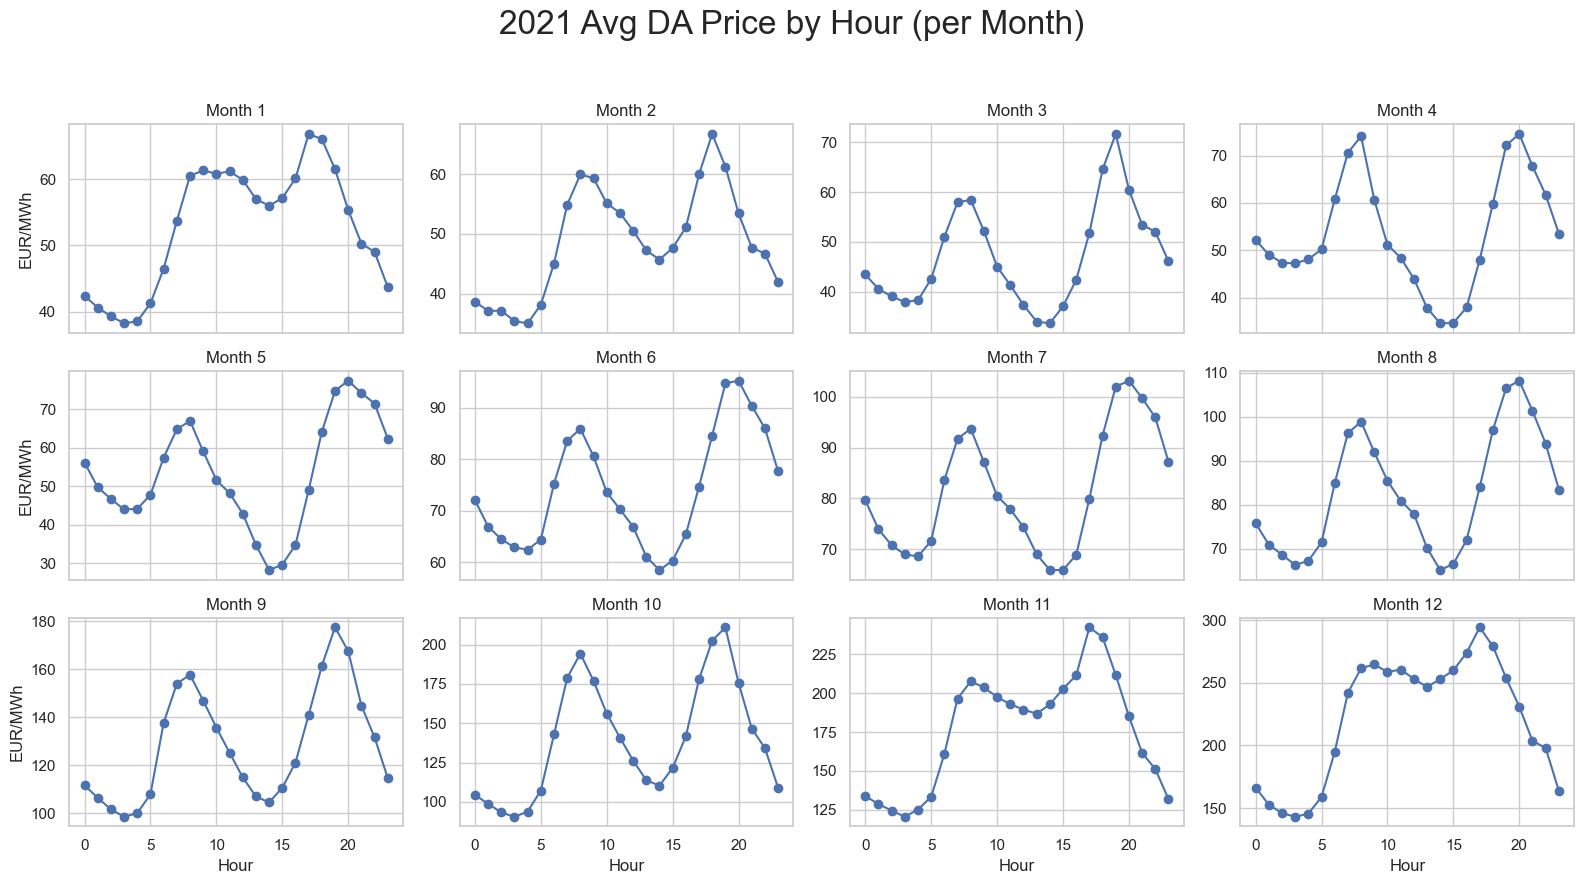

In [231]:
# Calculate average day ahead prices for each hour by month and create table for that
monthly_avg = (df.groupby([df.index.month, df.index.hour])['Day Ahead Price hourly [in EUR/MWh]'].mean().unstack(level=0))

# Plot each month in a 3x4 grid 
axes = monthly_avg.plot(
    subplots=True,
    layout=(3, 4),
    figsize=(16, 9),
    sharex=True,
    sharey=False,
    marker='o',
    legend=False,
    color='C0'                
)

# Add x axis label only in bottom row and y axis label only on the left column
for month_idx, ax in enumerate(axes.flatten(), start=1):
    ax.set_title(f"Month {month_idx}")
    ax.grid(True)
    if month_idx > 8:
        ax.set_xlabel("Hour")
    if (month_idx - 1) % 4 == 0:
        ax.set_ylabel("EUR/MWh")

# Add Title and adjust Layout
plt.suptitle("2021 Avg DA Price by Hour (per Month)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Since we see a pattern, that a lot of global minima can be seen before global maxima we want to know how often that is the case on a daily basis


In [232]:
# Find the timestamps of each day’s max/min DA price
idx_max = df.groupby('date')['Day Ahead Price hourly [in EUR/MWh]'].idxmax()
idx_min = df.groupby('date')['Day Ahead Price hourly [in EUR/MWh]'].idxmin()

# These idx_max and idx_min are Timestamps; turn them into Series indexed by date
max_time_series = pd.Series(idx_max.values, index=idx_max.index, name='max_time')
min_time_series = pd.Series(idx_min.values, index=idx_min.index, name='min_time')

# Count how many days the min came before the max
valid_days = (max_time_series > min_time_series).sum()
total_days = len(max_time_series)

# Print result
print(f"Days with min before max: {valid_days} of {total_days} ({valid_days/total_days:.1%})")

Days with min before max: 274 of 365 (75.1%)


Since the global minimum occurs before the global maximum in 75.1% of cases, I have devised the following strategy. Revenue_best_pair: Each day, the algorithm scans through the 24 hourly prices, continuously updating the lowest price seen so far and calculating the difference to each subsequent hour to identify the maximum possible “buy‐low, sell‐high” spread. By the end of the day, it returns that largest spread as the optimal single‐trade profit. However, since this assumes perfect knowledge of all day-ahead prices or better the exact time of the global minimum and global maximum, it is only possible with very good day-ahead price forecasting. I have therefore developed an alternative algorithm based on the monthly pattern that we were able to recognise. The algorithm revenue_fixed_hours_seasonal trades according to a fixed pattern in summer and a fixed pattern in winter. It buys electricity at the same time every day and sells it again at a fixed time. I have implemented both algorithms and compared their performance.


In [233]:

# Resample Day‑Ahead prices to one value per hour and group by day
da_hourly = df['Day Ahead Price hourly [in EUR/MWh]'].resample('h').first()
daily_da  = da_hourly.groupby(da_hourly.index.date)

# Index Intraday prices by time and group by day
intraday_hourly = df['Intraday Price Hourly  [in EUR/MWh]'].resample('h').first()
daily_id        = intraday_hourly.groupby(intraday_hourly.index.date)


# chronological best spread algorithm
def revenue_best_pair(daily_da_prices):
    """
    Greedy forward‑scan best‑pair:

    Input:
      daily_da_prices: iterable of (date, pd.Series) pairs, where each Series
                       contains 24 hourly day‑ahead prices for that date.
    Algorithm:
      1) For each day, track the lowest price seen so far.
      2) At each subsequent hour, compute the difference (spread) to that lowest price.
      3) Record the maximum spread as that day’s optimal buy‑low/sell‑high profit.
    Returns:
      total_revenue: float
      daily_series : pd.Series indexed by date
    """
    total_revenue = 0.0
    daily_revs = {}

    # Loop over each day's prices
    for delivery_date, hourly_series in daily_da_prices:
        prices = hourly_series.tolist()
        best_spread = 0.0
        # Initialize with first hour as the lowest seen so far
        lowest_price_so_far = prices[0]

        # Examine each subsequent hour
        for price in prices[1:]:
            # Calculate potential profit if bought at lowest_price_so_far and sold now
            spread = price - lowest_price_so_far
            # Update best_spread if this is the largest profit seen today
            if spread > best_spread:
                best_spread = spread
            # Update lowest_price_so_far if current price is a new trough
            if price < lowest_price_so_far:
                lowest_price_so_far = price

        # Store this day's best single‐trade profit
        daily_revs[delivery_date] = best_spread
        total_revenue += best_spread
    # Convert the daily results into a sorted pandas Series
    daily_series = pd.Series(daily_revs).sort_index()
    return total_revenue, daily_series

# Fixed hours algorithm for winter and summer time
def revenue_fixed_hours_seasonal(daily_da_prices, daily_id_prices):
    """
    Fixed‑Hour Arbitrage with simple seasonality:

    Input:
      daily_da_prices: iterable of (date, pd.Series) pairs, each with 24 hourly prices.
      daily_id_prices: same but for intraday prices.
    Algorithm:
      • In winter (Sep–Feb), charge (buy) at 03:00 and discharge (sell) at 19:00.
      • In summer (Mar–Aug), charge at 14:00 and discharge at 20:00.
      • Compute daily revenue as price_at_discharge – price_at_charge (can be negative).
    Returns:
      total_revenue: float
      daily_series : pd.Series indexed by date
    """
    total_revenue = 0.0
    daily_revs = {}

    for delivery_date, da_series in daily_da_prices:
        # get the matching intraday series
        id_series = daily_id_prices.get_group(delivery_date)

        # Determine season and select charge/discharge hours
        month = pd.to_datetime(delivery_date).month
        if month >= 9 or month <= 2:
            charge_hour, discharge_hour = 3, 19
        else:
            charge_hour, discharge_hour = 14, 20

        # Convert the day's prices to a list for indexing
        prices = da_series.tolist()
        id_prices = id_series.tolist()

        # Calculate revenue as the spread between discharge and charge hours
        revenue = id_prices[discharge_hour] - prices[charge_hour]

        # Record daily revenue and add to total
        daily_revs[delivery_date] = revenue
        total_revenue += revenue

    # Build a pandas Series of daily revenues, sorted by date
    daily_series = pd.Series(daily_revs).sort_index()
    return total_revenue, daily_series


# Run both algorithms
total_revenue_best_pair,   daily_revenue_best_pair   = revenue_best_pair(daily_da)
total_revenue_fixed_hours, daily_revenue_fixed_hours = revenue_fixed_hours_seasonal(daily_da, daily_id)

# Print results
print(f"Greedy forward‑scan best‑pair: €{total_revenue_best_pair:,.0f}")
print(f"Fixed‑Hour Arbitrage with simple seasonality: €{total_revenue_fixed_hours:,.0f}")


Greedy forward‑scan best‑pair: €27,790
Fixed‑Hour Arbitrage with simple seasonality: €20,980


With a total profit of €27,790 for 2021, the revenue_best_pair performed better than the revenue_fixed_hours_seasonal, which also posted a positive profit of €20,980. The plots for the daily performance and the cumulative performance of the two algorithms are shown below.

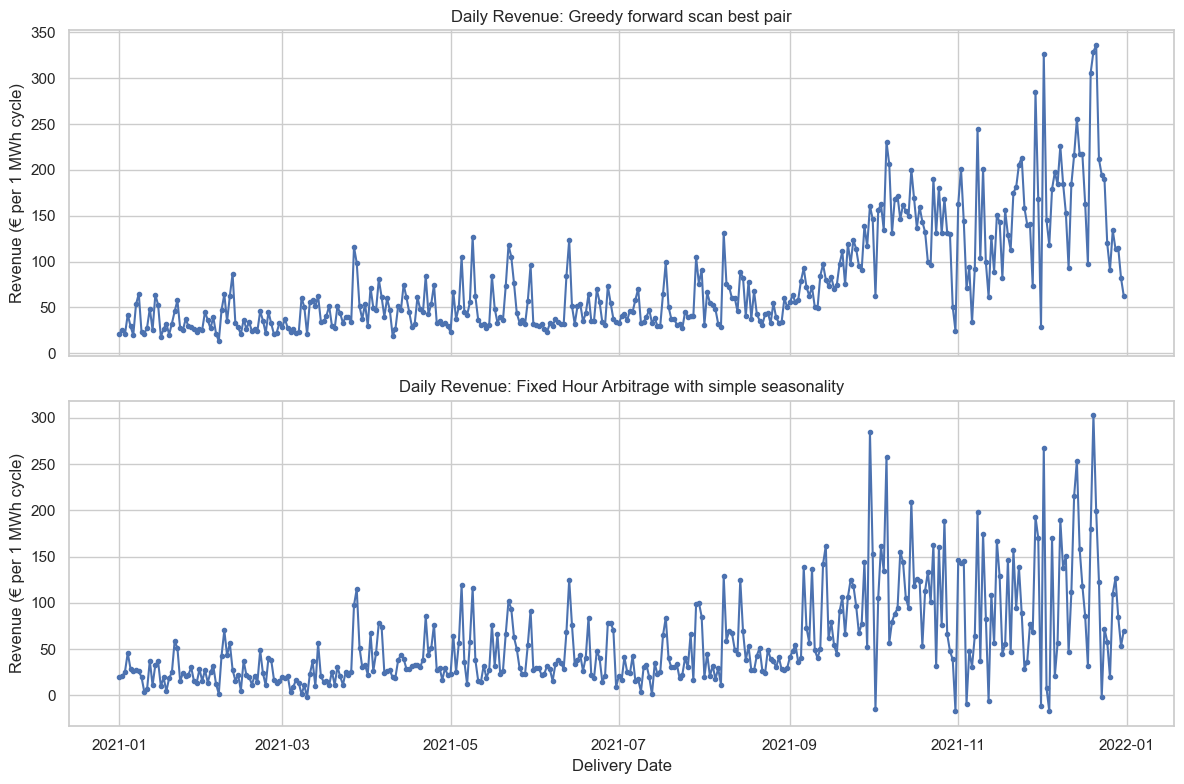

C:\Users\aaron\AppData\Local\Temp\ipykernel_29104\2599289011.py:41: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


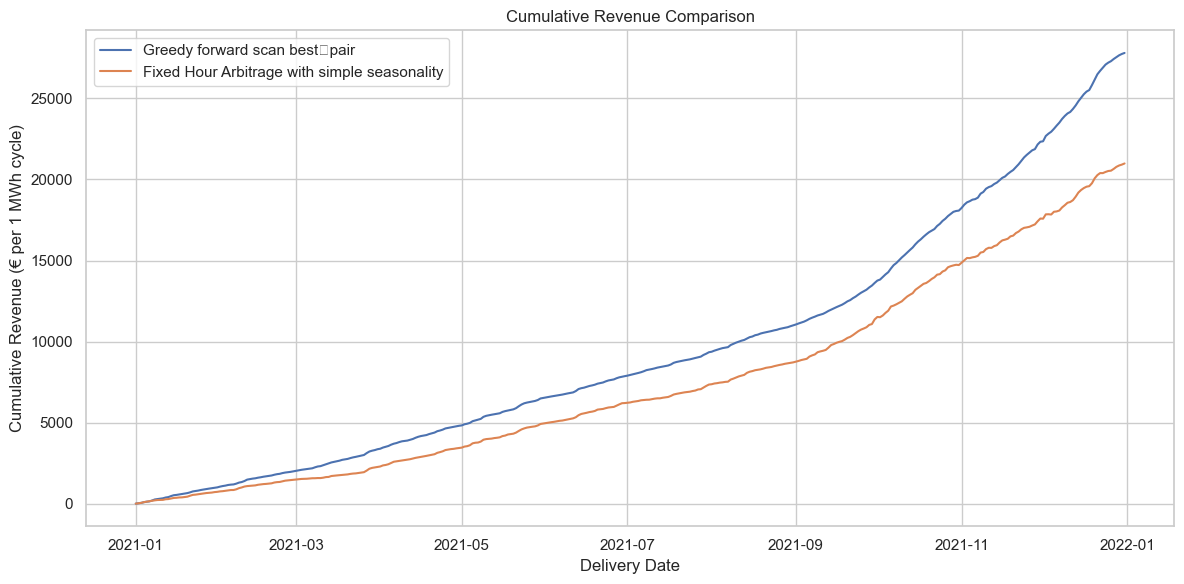

In [234]:
# Plot daily revenues as two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top subplot: Best‑Pair
daily_revenue_best_pair.plot(ax=ax1, marker='.', linestyle='-')
ax1.set_title("Daily Revenue: Greedy forward scan best pair")
ax1.set_ylabel("Revenue (€ per 1 MWh cycle)")
ax1.grid(True)

# Bottom subplot: Fixed‑Hours Seasonal
daily_revenue_fixed_hours.plot(ax=ax2, marker='.', linestyle='-')
ax2.set_title("Daily Revenue: Fixed Hour Arbitrage with simple seasonality")
ax2.set_xlabel("Delivery Date")
ax2.set_ylabel("Revenue (€ per 1 MWh cycle)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Compute cumulative revenues
cumulative_revenue_best = daily_revenue_best_pair.cumsum()
cumulative_revenue_fixed = daily_revenue_fixed_hours.cumsum()

# Plot both cumulative revenues together
plt.figure(figsize=(12, 6))
plt.plot(
    cumulative_revenue_best.index,
    cumulative_revenue_best.values,
    label="Greedy forward scan best‑pair",
)
plt.plot(
    cumulative_revenue_fixed.index,
    cumulative_revenue_fixed.values,
    label="Fixed Hour Arbitrage with simple seasonality",
)
plt.title("Cumulative Revenue Comparison")
plt.xlabel("Delivery Date")
plt.ylabel("Cumulative Revenue (€ per 1 MWh cycle)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

For all of 2021, both approaches made money from day-ahead price fluctuations, but their paths diverged in the fourth quarter. The greedy forward-scan best-pair approach entering trades at each day's low and its high—made money every day, racking up revenue in a string of steady profit. The fixed-hour seasonal arbitrage (charging at 03:00 and discharging at 19:00 during winter, charging at 14:00 and discharging at 20:00 during summer) also profited the majority of days, though it saw a couple of small losses towards the end of the year when its rigid hour choices came into conflict with extreme price movement.

When we overlay their running PnL curves, both techniques ride the same waves of volatility—especially Q4's crazy price swings but greedy forward-scan strategy becomes the clear winner as those price swings accelerate dramatically. Up until September 2021, the two methods keep in close sync (with best-pair consistently modestly ahead), but Q4's ruthless price highs and lows give best-pair method its margin of victory.

In theory, if you actually did have perfectly correct forecasts of each day's global minimum and maximum, the greedy forward‑scan strategy is certainly optimal. Reality is not quite so good, however. Under more realistic circumstances where you can't predict tomorrow's lowest and highest hours fixed hour seasonality rule is still a low‑complexity, attractive strategy that still captures most of the market's volatility premium.

## Task 2.7

In order to develop a trading strategy that is profitable, it is extremely important to understand the data we are working with. As deltas and price spreads can be an interesting tool due to the availability of day-ahead and intraday data, we first calculate the deltas of the renewable production forecasts and the spreads of the prices.

In [235]:
# Compute forecast deltas and price spread
df['wind_delta']    = df['Wind Intraday Forecast [in MW]'] - df['Wind Day Ahead Forecast [in MW]']
df['pv_delta']      = df['PV Intraday Forecast [in MW]']   - df['PV Day Ahead Forecast [in MW]']
df['net_delta']     = df['wind_delta'] + df['pv_delta']
df['price_spread']  = df['Intraday Price Hourly  [in EUR/MWh]'] - df['Day Ahead Price hourly [in EUR/MWh]']

We now calculate the correlations for these newly defined variables, as well as lagged variables, to see how large the time-dependent correlation is and whether this could represent a further tool for a strategy.

In [236]:
# Create hourly, daily, and weekly lags for selected variables
for col in ['wind_delta', 'pv_delta', 'net_delta', 'price_spread']:
    # 1-hour lag
    df[f'{col}_lag1']   = df[col].shift(1)
    # 24-hour (daily) lag
    df[f'{col}_lag24']  = df[col].shift(24)
    # 168-hour (weekly) lag
    df[f'{col}_lag168'] = df[col].shift(24 * 7)

# Build a list of original and lagged columns for correlation analysis
vars_to_corr = []
for base in ['wind_delta', 'pv_delta', 'net_delta', 'price_spread']:
    vars_to_corr.extend([
        base,
        f'{base}_lag1',
        f'{base}_lag24',
        f'{base}_lag168'
    ])

# Compute the correlation matrix among all selected series
correlation_analysis = df[vars_to_corr].corr()

# Display the resulting correlation matrix
print(correlation_analysis)


                     wind_delta  wind_delta_lag1  wind_delta_lag24  \
wind_delta             1.000000         0.986706          0.494106   
wind_delta_lag1        0.986706         1.000000          0.509833   
wind_delta_lag24       0.494106         0.509833          1.000000   
wind_delta_lag168      0.006072         0.005694          0.031067   
pv_delta              -0.057753        -0.056805         -0.019121   
pv_delta_lag1         -0.058600        -0.057766         -0.019229   
pv_delta_lag24        -0.021777        -0.024314         -0.057977   
pv_delta_lag168       -0.023673        -0.024482         -0.005135   
net_delta              0.898979         0.887106          0.448318   
net_delta_lag1         0.886305         0.898959          0.462801   
net_delta_lag24        0.447051         0.460469          0.898658   
net_delta_lag168      -0.004768        -0.005470          0.026381   
price_spread          -0.399147        -0.398053         -0.229593   
price_spread_lag1   

The correlation matrix gives us the first interesting insights into our data and how they are influenced by each other. Firstly, we see that the deltas for wind, solar and aggregate have time-dependent correlations, which are low but still minimally persistent over a week. Furthermore, we see a strong negative correlation between Renewebales delta and price spreads that persists over time. We will now illustrate these relationships graphically.

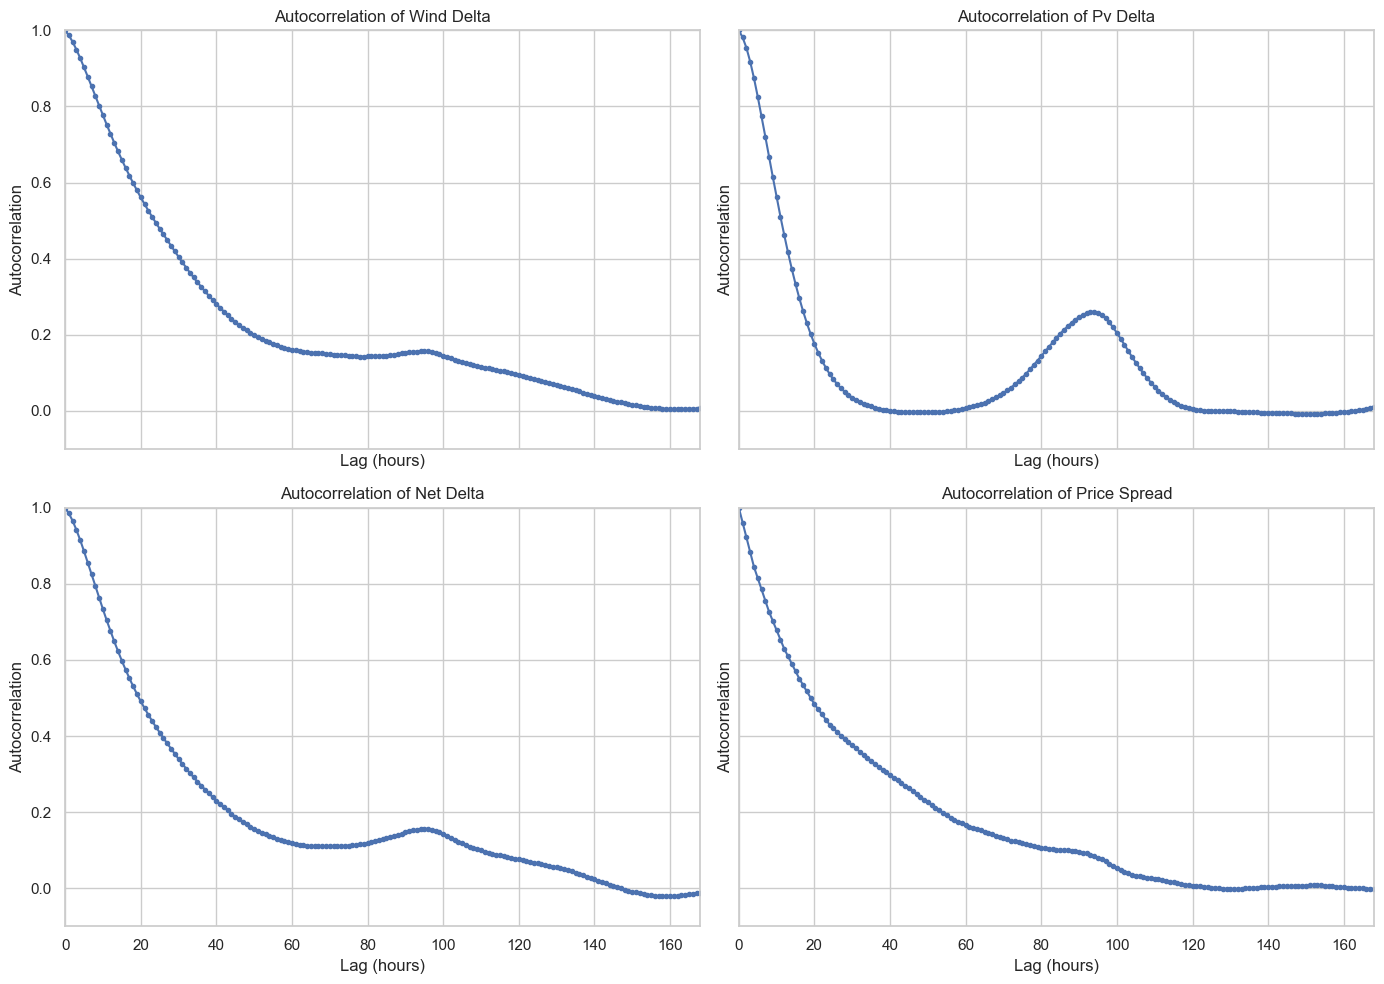

In [237]:
# Variables to analyze
variables = ['wind_delta', 'pv_delta', 'net_delta', 'price_spread']
max_lag = 168  # up to one week

# Compute autocorrelations for each variable at lags 0 through 168 hours
autocorrs = {
    var: [df[var].autocorr(lag=lag) for lag in range(max_lag + 1)]
    for var in variables
}

# Plotting a 2x2 grid of autocorrelation functions
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, var in zip(axes, variables):
    ax.plot(
        range(max_lag + 1),
        autocorrs[var],
        marker='o',
        markersize=3,
        linestyle='-',
        color='C0'  
    )
    ax.set_title(f'Autocorrelation of {var.replace("_", " ").title()}')
    ax.set_xlim(0, max_lag)
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel('Lag (hours)')
    ax.set_ylabel('Autocorrelation')
    ax.grid(True)

plt.tight_layout()
plt.show()

As we can see in the autocorrelation charts, wind delta and price spreads in particular have a long-lasting autocorrelation that persists for several days. These could therefore be good inputs for our trading strategy. For PV we also see a very interesting pattern, which shows that the autocorrelation drops relatively quickly but returns between hour 80 and 100. This time frame could therefore offer an interesting opportunity to also include autocorrelations of PV deltas 


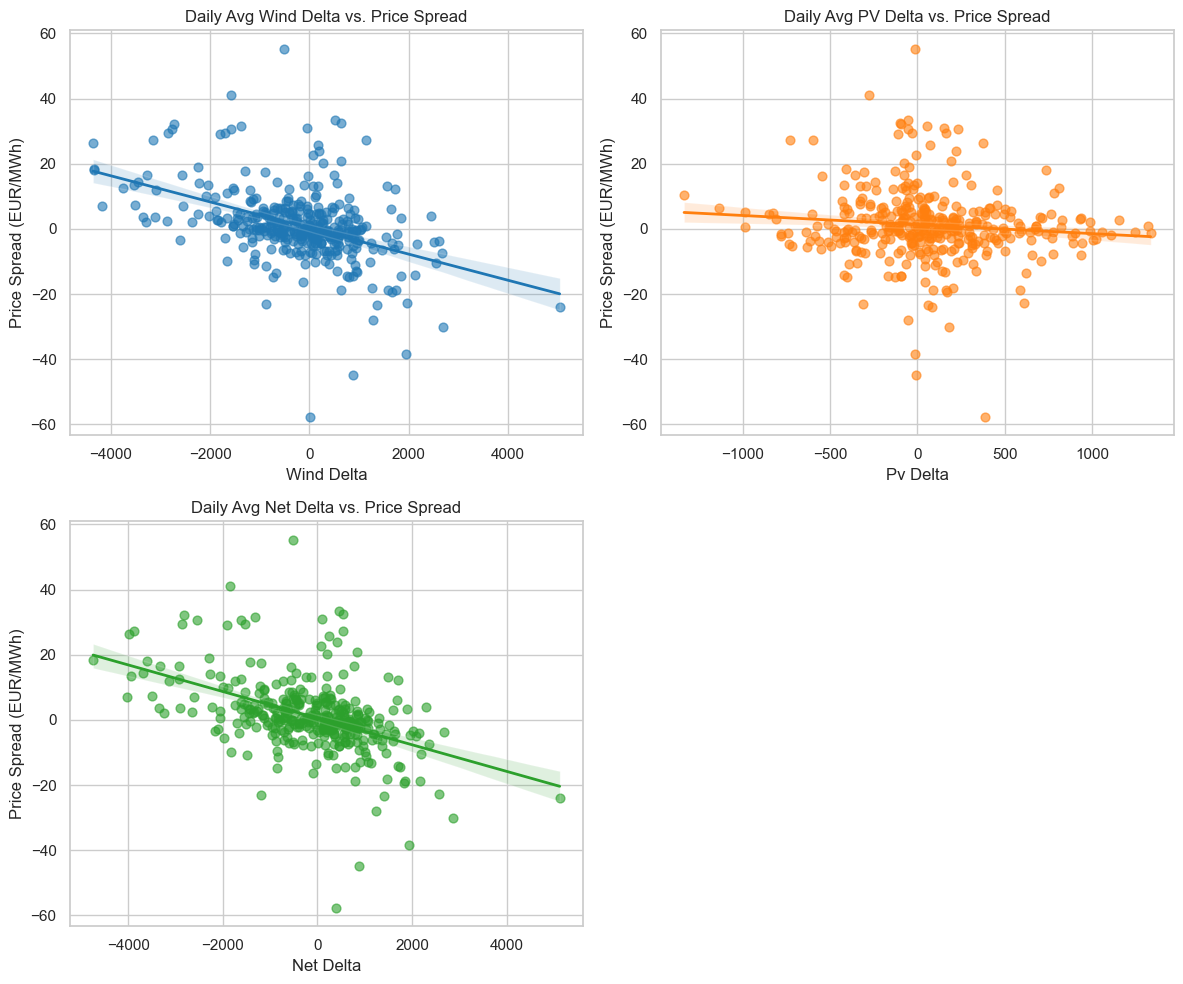

In [238]:
# Compute daily averages for deltas and price spread
daily = df[['wind_delta','pv_delta','net_delta','price_spread']].resample('D').mean()

# Use seaborn style
sns.set_theme(style="whitegrid")

# Create a 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
axes = axes.flatten()

# Plot configurations: (column, title, color)
configs = [
    ('wind_delta', 'Daily Avg Wind Delta vs. Price Spread', 'tab:blue'),
    ('pv_delta',   'Daily Avg PV Delta vs. Price Spread',   'tab:orange'),
    ('net_delta',  'Daily Avg Net Delta vs. Price Spread',  'tab:green'),
]

# Loop over the first three axes and plot
for ax, (col, title, color) in zip(axes, configs):
    sns.regplot(
        x=daily[col], y=daily['price_spread'],
        ax=ax,
        scatter_kws={'s': 40, 'alpha': 0.6, 'marker': 'o', 'color': color},
        line_kws   ={'lw': 2, 'color': color}
    )
    ax.set_title(title)
    ax.set_ylabel('Price Spread (EUR/MWh)')
    ax.set_xlabel(col.replace('_', ' ').title())

# Turn off the unused fourth subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()

Here we see that wind deltas in particular have a strong negative correlation with price spreads, but this can also be found in PV deltas. Even if this is lower, it could have descriptive power. All in all, we can see that an unanticipated overproduction of renewable energies can have a negative impact on the price, which we can exploit to our advantage.

Before we implement the trading strategy, let's take a closer look at the price spreads. It is interesting to see if there are any patterns here. Therefore, we look at the average spreads for each hour of the day as well as the comparison on a monthly basis.

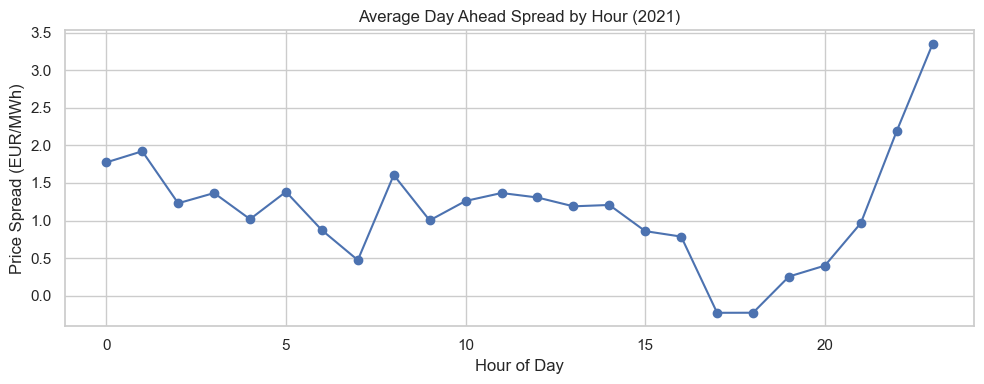

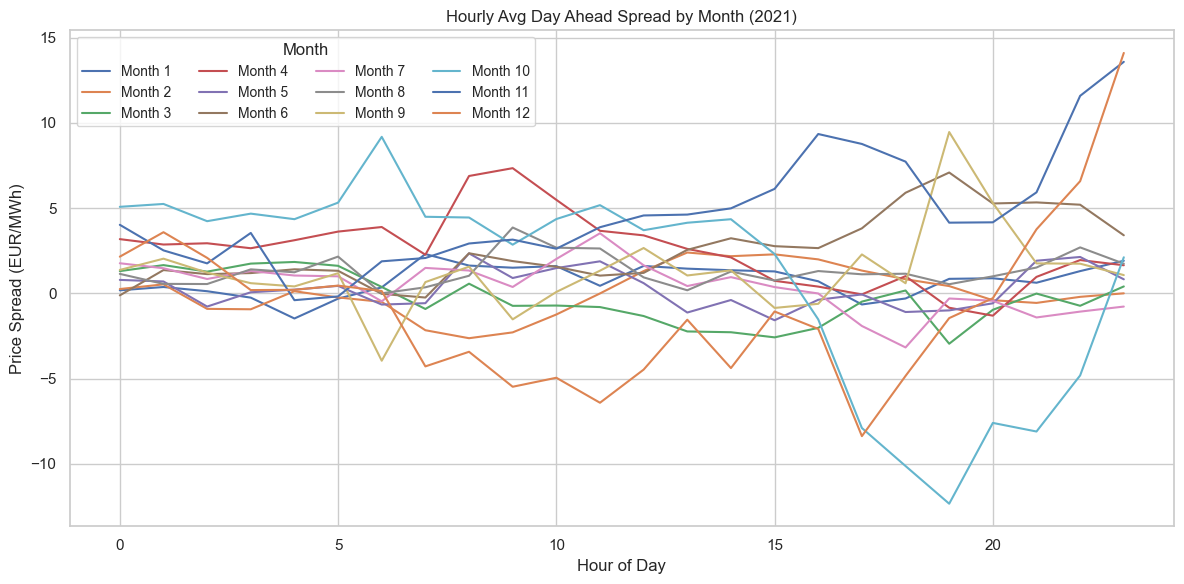

In [239]:
# Compute the overall average spread for each hour of the day
hourly_avg = df.groupby(df.index.hour)['price_spread'].mean()

# Compute the average spread for each hour, broken out by month
monthly_hourly_avg = (df.groupby([df.index.month, df.index.hour])['price_spread'].mean().unstack(level=0))

# Plot overall hourly average spread
plt.figure(figsize=(10, 4))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='C0')
plt.title("Average Day Ahead Spread by Hour (2021)")
plt.xlabel("Hour of Day")
plt.ylabel("Price Spread (EUR/MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot monthly comparisons: one line per month
fig, ax = plt.subplots(figsize=(12, 6))
for month in monthly_hourly_avg.columns:
    ax.plot(
        monthly_hourly_avg.index,
        monthly_hourly_avg[month],
        label=f"Month {month}"
    )
ax.set_title("Hourly Avg Day Ahead Spread by Month (2021)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Price Spread (EUR/MWh)")
ax.legend(ncol=4, fontsize='small', title="Month")
ax.grid(True)
plt.tight_layout()
plt.show()

We can see that the spreads are at their widest at night. If we look at the average over the year, the 23 hour (23:00-00:00) seems to have the greatest potential. Even on a monthly basis, we can see that, with the exception of month 7 (July), only positive spreads can be found here. In order to be able to compare the performance of our trading strategy, we will develop a trading strategy as a benchmark that always buys electricity on the day-ahead market at a fixed time and sells it on the intraday market. For this we will compare every 24h and see for which the cumulated PnL is the highest.

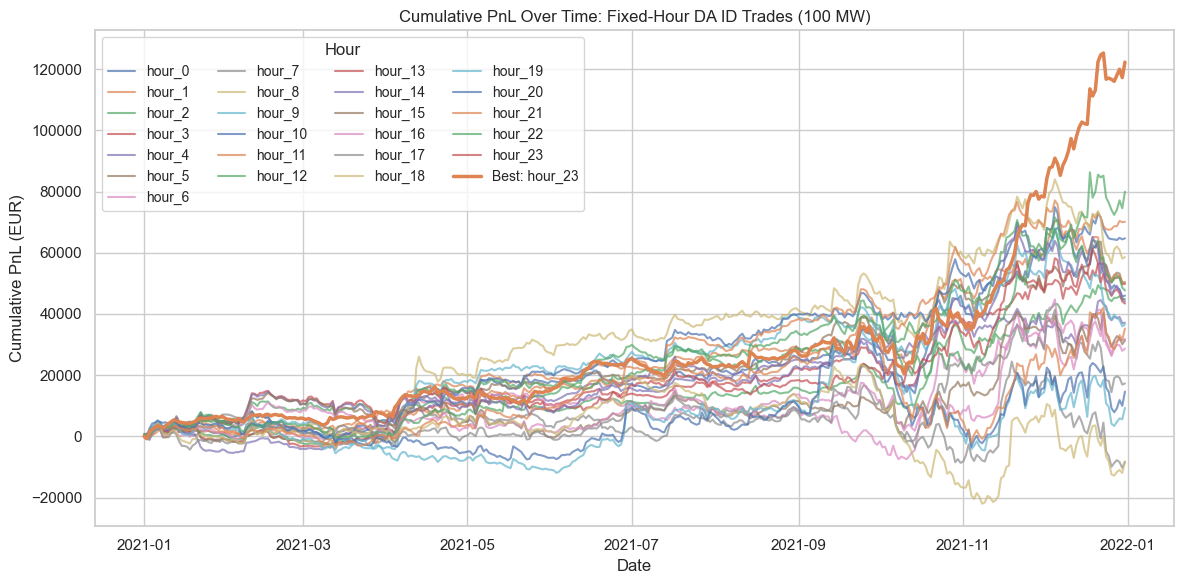

In [240]:
# Simulate fixed-hour trade for each hour: buy DA, sell ID at same top-of-hour
df_hourly = df[df.index.minute == 0]
trade_volume = 100  # MW
all_daily_pnl = pd.DataFrame()

for hour in range(24):
    # filter to this hour
    mask = df_hourly.index.hour == hour
    daily = df_hourly.loc[mask].copy()
    # compute spread * volume
    daily['pnl'] = (daily['Intraday Price Hourly  [in EUR/MWh]'] 
                    - daily['Day Ahead Price hourly [in EUR/MWh]']) * trade_volume
    # group by date and sum PnL per day
    daily_series = daily.groupby(daily.index.date)['pnl'].sum()
    all_daily_pnl[f'hour_{hour}'] = daily_series

# align dates and fill missing with 0
all_daily_pnl = all_daily_pnl.fillna(0).sort_index()

# Compute cumulative over time
cum_pnl = all_daily_pnl.cumsum()

# Plot cumulative PnL lines for each hour
plt.figure(figsize=(12, 6))
for col in cum_pnl.columns:
    plt.plot(cum_pnl.index, cum_pnl[col], label=col, alpha=0.7)

# Highlight the best hour
total_pnl_per_hour = cum_pnl.iloc[-1]
best_hour = total_pnl_per_hour.idxmax()
plt.plot(cum_pnl.index, cum_pnl[best_hour], color='C1', linewidth=2.5, label=f'Best: {best_hour}')

plt.xlabel('Date')
plt.ylabel('Cumulative PnL (EUR)')
plt.title('Cumulative PnL Over Time: Fixed-Hour DA ID Trades (100 MW)')
plt.legend(ncol=4, fontsize='small', title='Hour')
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that the fixed hour strategy for hour_23 leads to best cummulative PnL for the year 2021 with a profit of around €120,000. This will now be used as our benchmark to compare our trading strategy to.

For the trading strategy I decided for a "24‑Hour Spread Regression Strategy" using Random Forest models. The idea is Each day $d$, we use 24 separate Random Forest regressors to predict the intraday–day‑ahead price spread $\hat s_{d,h}$ for each hour $h$. We then choose the hour

$$
\hat h_d \;=\;\arg\max_{0 \le h < 24}\;\hat s_{d,h}
$$

and execute a 100 MW buy at the day‑ahead price and sell at the intraday price, yielding daily PnL

$$
\mathrm{PnL}_d \;=\;\bigl(\mathrm{price\_id}_{d,\hat h_d} - \mathrm{price\_da}_{d,\hat h_d}\bigr)\,\times\,100.
$$

For that we first need to define our potential features for the model and define the data. Here’s a quick rundown of the features we feed into the model:

Day‑Ahead Forecasts
– Wind Day Ahead Forecast [in MW], PV Day Ahead Forecast [in MW]
These are the actual production forecasts known at the d – 1 12:00 auction.

Lagged DA Forecasts
– wind_da_lag24, pv_da_lag24 plus their 24‑h rolling mean/std (wind_da_ma24, wind_da_std24, …)
Captures momentum and volatility in the forecasts themselves, i.e. how yesterday’s forecast evolved.

Lagged Forecast Errors (“Deltas”)
– wind_delta_lag24/48/72/96, pv_delta_lag24/48/72/96
The intraday – day‑ahead forecast differences from the last 1–4 days, to model systematic bias or correction patterns.

Lagged Price Spreads
– spread_lag24/48/72/96
Yesterday’s (and earlier) intraday – day‑ahead price gaps, which tend to autocorrelate.

Rolling Spread Statistics
– spread_ma24, spread_std24, spread_ma168, spread_std168
Recent average and volatility of the price spread over the past 1 day and 1 week.

Rolling Delta Statistics
– wind_delta_ma24, wind_delta_std24, pv_delta_ma24, pv_delta_std24
Recent mean and volatility of forecast errors, helping the model gauge forecast reliability.

Calendar Flags
– is_holiday, weekday, is_weekend, month
Captures predictable demand/supply shifts on weekends, holidays and across seasons.

All of these are known at the close of the day‐ahead auction (d – 1 12:00) and help the model predict which hour tomorrow will have the largest intraday spread.








In [241]:
#Filter to top‑of‑hour rows (minute == 0)
df_h = df[df.index.minute == 0].copy()

# 2) Pull “time” and extract calendar fields
df_h['time']       = df_h.index
df_h['date']       = df_h.index.date
df_h['hour']       = df_h.index.hour
df_h['weekday']    = df_h.index.weekday      # 0=Mon … 6=Sun
df_h['is_weekend'] = df_h['weekday'] >= 5
df_h['month']      = df_h.index.month

# Mark fixed public holidays in 2021
holiday_list = [
    "2021-01-01","2021-04-02","2021-04-05",
    "2021-05-01","2021-05-13","2021-05-24",
    "2021-10-03","2021-12-25","2021-12-26"
]
holidays = pd.to_datetime(holiday_list).date
df_h['is_holiday'] = df_h['date'].isin(holidays)

# Compute current deltas/spread so we can lag them
df_h['wind_delta']   = df_h['Wind Intraday Forecast [in MW]'] - df_h['Wind Day Ahead Forecast [in MW]']
df_h['pv_delta']     = df_h['PV Intraday Forecast [in MW]']   - df_h['PV Day Ahead Forecast [in MW]']
df_h['price_spread'] = df_h['Intraday Price Hourly  [in EUR/MWh]'] - df_h['Day Ahead Price hourly [in EUR/MWh]']

# Build lagged features for wind_delta, pv_delta, and price_spread
for lag in [24, 48, 72, 96]:
    df_h[f'wind_delta_lag{lag}'] = df_h['wind_delta'].shift(lag)
    df_h[f'pv_delta_lag{lag}'] = df_h['pv_delta'].shift(lag)
    df_h[f'spread_lag{lag}'] = df_h['price_spread'].shift(lag)

#  Rolling window spread mean & std
df_h['spread_ma24'] = df_h['price_spread'].rolling(24).mean().shift(1)
df_h['spread_ma168'] = df_h['price_spread'].rolling(168).mean().shift(1)
df_h['spread_std24'] = df_h['price_spread'].rolling(24).std().shift(1)
df_h['spread_std168'] = df_h['price_spread'].rolling(168).std().shift(1)

# Rolling Window delta mean & std
df_h['wind_delta_ma24'] = df_h['wind_delta'].rolling(24).mean().shift(1)
df_h['wind_delta_std24'] = df_h['wind_delta'].rolling(24).std().shift(1)
df_h['pv_delta_ma24'] = df_h['pv_delta'].rolling(24).mean().shift(1)
df_h['pv_delta_std24'] = df_h['pv_delta'].rolling(24).std().shift(1)

# Lagged DA forecasts and their rolling stats
df_h['wind_da_lag24'] = df_h['Wind Day Ahead Forecast [in MW]'].shift(24)
df_h['pv_da_lag24'] = df_h['PV Day Ahead Forecast [in MW]'].shift(24)
df_h['wind_da_ma24'] = df_h['Wind Day Ahead Forecast [in MW]'].rolling(24).mean().shift(1)
df_h['wind_da_std24'] = df_h['Wind Day Ahead Forecast [in MW]'].rolling(24).std().shift(1)
df_h['pv_da_ma24'] = df_h['PV Day Ahead Forecast [in MW]'].rolling(24).mean().shift(1)
df_h['pv_da_std24'] = df_h['PV Day Ahead Forecast [in MW]'].rolling(24).std().shift(1)

# Drop the now‑unusable “current” columns
df_h = df_h.drop(columns=['wind_delta', 'pv_delta', 'price_spread'])

# Assemble final feature list
feature_cols = [
    # day‑ahead forecasts
    'Wind Day Ahead Forecast [in MW]',
    'PV Day Ahead Forecast [in MW]',

    # lagged DA forecasts
    'wind_da_lag24', 'wind_da_ma24', 'wind_da_std24',
    'pv_da_lag24',   'pv_da_ma24',   'pv_da_std24',

    # lagged deltas
    'wind_delta_lag24', 'wind_delta_lag48',
    'wind_delta_lag72', 'wind_delta_lag96',
    'pv_delta_lag24',   'pv_delta_lag48',
    'pv_delta_lag72',   'pv_delta_lag96',

    # lagged spreads
    'spread_lag24', 'spread_lag48',
    'spread_lag72', 'spread_lag96',

    # rolling spread stats
    'spread_ma24', 'spread_ma168',
    'spread_std24', 'spread_std168',

    # rolling delta stats
    'wind_delta_ma24',  'wind_delta_std24',
    'pv_delta_ma24',    'pv_delta_std24',

    # calendar flags
    'is_holiday', 'weekday', 'is_weekend', 'month'
]

# Build a clean DataFrame containing features + target + date
df_clean = (
    df_h[['time','date','hour'] + feature_cols]
    .assign(
      target=lambda d: (
        df_h['Intraday Price Hourly  [in EUR/MWh]']
        - df_h['Day Ahead Price hourly [in EUR/MWh]']
      )
    )
    .dropna()
)

X = df_clean[feature_cols]
y = df_clean['target']
all_dates = sorted(df_clean['date'].unique())

To find a good number of trees for our Random Forest regressors without over‑spending CPU time, we ran a quick “elbow‑curve” sweep on just January’s data. For each candidate 
𝑛_estimators, we trained a forest with out‑of‑bag (OOB) scoring enabled and recorded its OOB error (1-R^2). This lets us gauge generalization quality directly on the training set, so we don’t have to hold out an extra validation split.

C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators=  10 → OOB RMSE≈4.888
n_estimators=  25 → OOB RMSE≈4.270
n_estimators=  50 → OOB RMSE≈4.035
n_estimators= 100 → OOB RMSE≈3.960
n_estimators= 150 → OOB RMSE≈3.910
n_estimators= 200 → OOB RMSE≈3.887
n_estimators= 300 → OOB RMSE≈3.859
n_estimators= 400 → OOB RMSE≈3.835
n_estimators= 500 → OOB RMSE≈3.813
n_estimators= 600 → OOB RMSE≈3.806
n_estimators= 700 → OOB RMSE≈3.817
n_estimators= 800 → OOB RMSE≈3.831
n_estimators= 900 → OOB RMSE≈3.837
n_estimators=1000 → OOB RMSE≈3.850


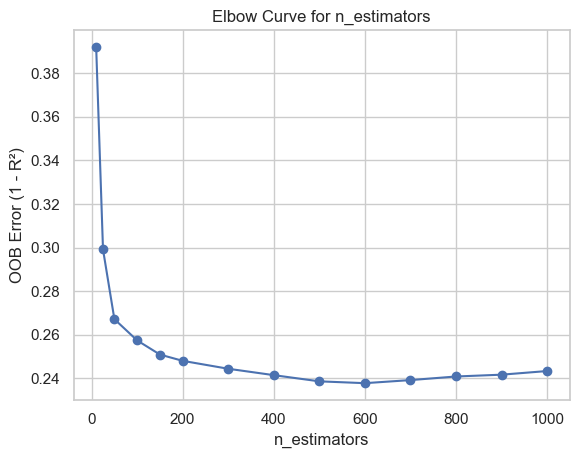

In [242]:
# Subset January for Model selection
jan_mask = df_h['time'].dt.month == 1
X_jan    = X.loc[jan_mask, feature_cols]
y_jan    = df_clean.loc[jan_mask, 'target']

# Candidate n_estimators
candidates = [10, 25, 50, 100, 150, 200, 300, 400, 500,600,700,800,900,1000]
oob_errors = []

# Fit with OOB and record OOB error (1 - R²)
for n in candidates:
    rf = RandomForestRegressor(
        n_estimators=n,
        oob_score=True,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_jan, y_jan)
    oob_err = 1 - rf.oob_score_
    oob_errors.append(oob_err)
    print(f"n_estimators={n:4d} OOB RMSE≈{np.sqrt(oob_err*np.var(y_jan)):.3f}")

# Plot OOB error vs. n_estimators
plt.plot(candidates, oob_errors, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error (1 - R²)')
plt.title('Elbow Curve for n_estimators')
plt.grid(True)
plt.show()


When we plotted OOB error against 𝑛_estimators, the error plunged sharply as we increased tree count from 10 up to around 400, then flattened out. Beyond 400 trees the incremental reduction in error was negligible compared to the extra training time. Thus, we selected 400 as the sweet‑spot enough trees to capture the signal without wasting compute on vanishing returns.

Total PnL: €97,234


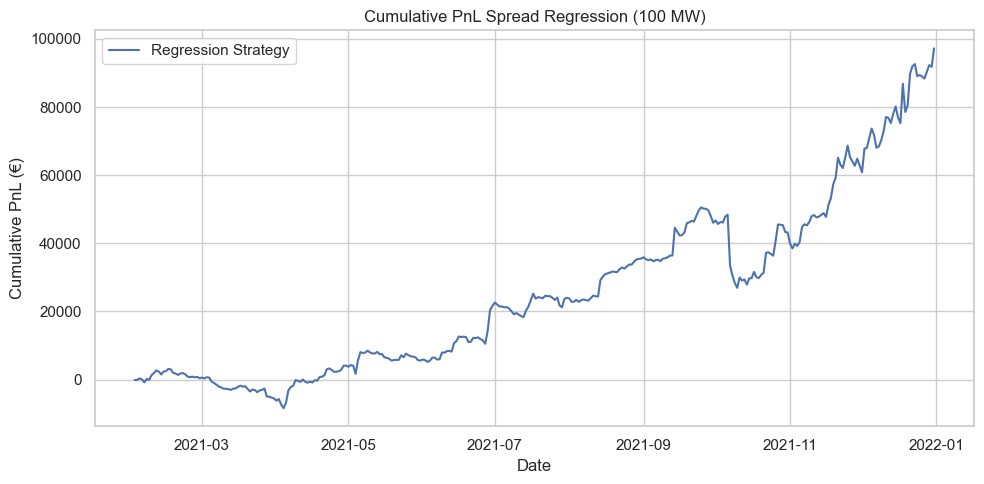

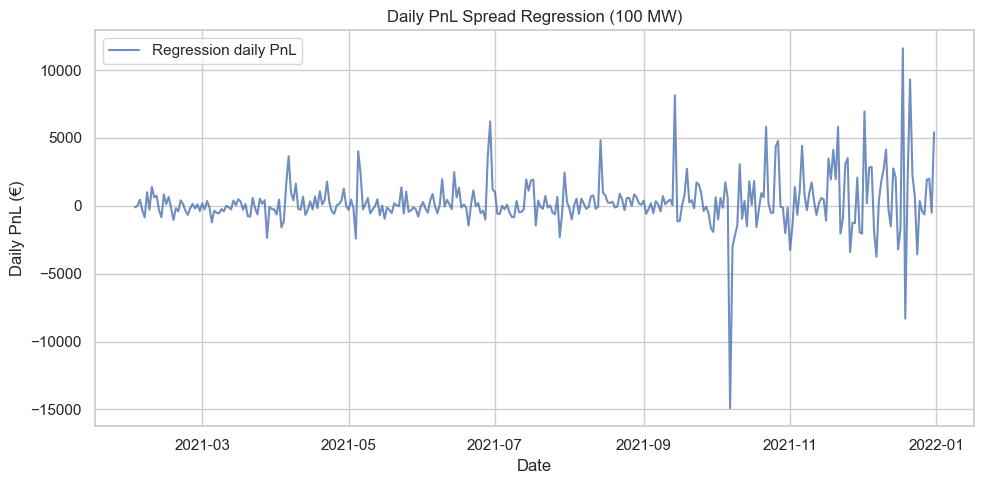

In [243]:
def Spread_Regression_Strategy(df_h,feature_cols,n_estimators,volume=100):
    """
    Spread‑Regression Trading Strategy:

    Input:
      df_h:        DataFrame with hourly rows indexed by timestamp, containing
                   'date', 'hour', day‑ahead & intraday price columns, plus features.
      feature_cols: list of feature column names to use in regression.
      n_estimators: number of trees for each RandomForestRegressor.
      volume:      position size in MW (default=100).

    Algorithm:
      • Recompute the true daily spread = intraday_price − dayahead_price.
      • For each test month M = Feb…Dec:
        1) Train 24 separate RF regressors (one per hour) on all months < M.
        2) Predict hourly spreads in month M using the corresponding regressor.
        3) For each calendar day, select the hour with the highest predicted spread.
        4) Execute the trade: buy at DA price, sell at ID price for that hour.
        5) Record daily PnL = (ID − DA) × volume.

    Returns:
      DataFrame indexed by date with columns:
        • 'pnl'     — daily profit & loss in €
        • 'cum_pnl' — cumulative P&L over the backtest period
    """
    # make local copy and rebuild the target
    df = df_h.copy()
    df['price_spread'] = df['Intraday Price Hourly  [in EUR/MWh]'] - df['Day Ahead Price hourly [in EUR/MWh]']

    records = []
    # Loop over test months February…December
    for test_month in range(2, 13):
        train = df[df['month'] < test_month]
        test  = df[df['month'] == test_month].copy()

        # Train per-hour regressors
        models = {}
        for h in range(24):
            mask_tr = train['hour'] == h
            Xtr = train.loc[mask_tr, feature_cols]
            ytr = train.loc[mask_tr, 'price_spread']
            rf = RandomForestRegressor(
                n_estimators=n_estimators,
                random_state=42,
                n_jobs=-1
            )
            rf.fit(Xtr, ytr)
            models[h] = rf

        # Predict in test set
        test['pred_spread'] = 0.0
        for h, rf in models.items():
            mask_te = test['hour'] == h
            Xte = test.loc[mask_te, feature_cols]
            test.loc[mask_te, 'pred_spread'] = rf.predict(Xte)

        # Execute PnL per day
        for date, group in test.groupby('date'):
            best_idx = group['pred_spread'].idxmax()
            row = group.loc[best_idx]
            pnl = (row['Intraday Price Hourly  [in EUR/MWh]'] - row['Day Ahead Price hourly [in EUR/MWh]']) * volume
            records.append({'date': date, 'pnl': pnl})

    # Compile results
    df_pnl = pd.DataFrame(records).set_index('date').sort_index()
    df_pnl['cum_pnl'] = df_pnl['pnl'].cumsum()
    return df_pnl

# Run the strategy
df_pnl = Spread_Regression_Strategy(df_h, feature_cols, n_estimators=400, volume=100)

# Calculate and print total PnL
total_pnl = df_pnl['pnl'].sum()
print(f"Total PnL: €{total_pnl:,.0f}")

# Plot cumulative PnL
plt.figure(figsize=(10,5))
plt.plot(df_pnl.index, df_pnl['cum_pnl'], label='Regression Strategy')  
plt.title("Cumulative PnL Spread Regression (100 MW)")  
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Plot daily returns
plt.figure(figsize=(10,5))
plt.plot(df_pnl.index, df_pnl['pnl'], label='Regression daily PnL', alpha=0.8)  
plt.title("Daily PnL Spread Regression (100 MW)")  
plt.xlabel("Date")
plt.ylabel("Daily PnL (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

During 2021, our spread‐regression strategy generated a total PnL of €97 234, with the cumulative equity curve increasing consistently after the rolling‐window backtest had accumulated enough training data (chart). Limited history led to an initial small drawdown, but as each subsequent month added to the model, performance picked up.

Daily returns followed a generally upward pattern with, however, severe dips in between—most notably a single day when there was a fall of approximately –€15,000. The tail event happens when the model's forecasted "optimal" hour abruptly goes off-target, illustrating the method's sensitivity to abrupt regime change or overfitting to outdated patterns. In practice, we would mitigate this by imposing drawdown limits, implementing spread thresholds, or applying ensemble filters to moderate excessively bold forecasts and limit outsized losses.

In contrast, our simple "fixed-hour" benchmark—buying and selling at hour 23 each day—would have made approximately €120,000 over the year; but this performance is entirely attributable to our backtest selection of the optimal hour with complete hindsight.

Why should the regression strategy work at all? Because forecast errors for renewables ("deltas") and historical price‑spread autocorrelations do contain genuine predictive power. Inputting lagged deltas, rolling‐window spread means and volatilities, lagged day‑ahead forecasts, and calendar flags into a Random Forest model enables us to adaptively choose, each morning, the hour most likely to provide the highest intraday spread.

All of that being true, however, as forecasting and weather systems improve, the availability of exploitable forecast "mistakes" will diminish, and profitable arbitrage will be less certain. However, this strategy lays a firm base combining machine learning and subject matter expertise and with properly designed risk-management overlays, it certainly has the potential to remain profitable even as market circumstances evolve.